<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="680" height="140" align="right"/>

<h4 style="text-align: center;">Curso: Proyecto de grado 2</h4>
<h4 style="text-align: center;">Tarea: Fase 1</h4>
<h4 style="text-align: center;">Presentado por: Oscar Andrés Russi Porras</h4>
<h4 style="text-align: center;">Universidad Nacional Abierta y a Distancia – UNAD</h4>
<h4 style="text-align: center;">Fecha: Abril de 2025</h4>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import datetime
from IPython.display import display
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Conectar datos

In [2]:
import urllib
from sqlalchemy import create_engine
import pandas as pd
columns_to_check = ['price', 'habitaciones', 'banyos', 'estrato', 'areaConstruida',
                        'areaPrivada', 'parqueaderos', 'administracion', 'pisoNumero', 'totalPisos']

params = urllib.parse.quote_plus(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-KNKLQ23\MSSQLSERVER01;DATABASE=inmuebles;"
    "UID=oscarrussi;PWD=asdf1234;"
)

# "mssql+pyodbc" es el dialecto para SQL Server a través de pyodbc
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [3]:
query = "select * from dbo.datosVivienda where (price is not null and price<>'') and (ubicacion is not null and ubicacion<>'')"
df = pd.read_sql(query, engine)

print(df.head())

          price  habitaciones  \
0  1.200000e+08           2.0   
1  1.050000e+08           1.0   
2  7.850000e+09           1.0   
3  2.200000e+10           1.0   
4  1.071588e+11           NaN   

                                              descr  \
0                              Apartamento en venta   
1              Edificio en venta, Bogotá - Germania   
2  Edificio en venta, Bogotá - Primavera Occidental   
3                                   Bodega en venta   
4                                     Lote en venta   

                                                link  banyos       id  \
0  https://www.fincaraiz.com.co/apartamento-en-ve...     1.0  2351795   
1  https://www.fincaraiz.com.co/edificio-en-venta...     NaN  3056432   
2  https://www.fincaraiz.com.co/edificio-en-venta...     2.0  3072117   
3  https://www.fincaraiz.com.co/bodega-en-venta/3...     NaN  3129789   
4  https://www.fincaraiz.com.co/lote-en-venta/314...     NaN  3149801   

  tipoInmueble   estadoInmueble

# Exploración preliminar

In [4]:
df= df[df["tipoInmueble"]=="Apartamento"]
df = df.drop(columns="tipoInmueble")

## Caracterización general de la muestra 

In [5]:
pd.set_option('display.float_format', '{:.2f}'.format)
main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","pisoNumero","totalPisos"]
summary = df[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion,pisoNumero,totalPisos
count,7840.00,7836.00,7834.00,7808.00,7839.00,7322.00,5617.00,7508.00,7464.00,6877.00
mean,5282903183.65,2.62,2.26,4.15,98.88,74.46,1.67,3097791.43,4.65,1.68
std,77667182329.77,0.80,1.11,1.29,79.80,78.01,0.94,43218820.61,4.10,3.22
min,508000.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00
25%,255700000.00,2.00,2.00,3.00,52.00,35.00,1.00,144627.50,2.00,0.00
50%,430000000.00,3.00,2.00,4.00,73.00,59.00,1.00,333600.00,4.00,0.00
75%,761250000.00,3.00,3.00,5.00,114.00,94.00,2.00,730000.00,6.00,2.00
max,3240000000000.00,20.00,21.00,6.00,900.00,900.00,11.00,2000000000.00,21.00,21.00


## Calidad de la información

In [6]:
df_nuevo = df
def discrete_variable_summary(df):
    summaries = []
    excluir = ['comodidades', 'date_created', 'date_modified']
    columnas_a_excluir = [col for col in excluir if col in df.columns]
    df_resultado = df.drop(columns=columnas_a_excluir)
    
    total = df.shape[0]  # total de registros incluyendo nulos
    
    for column in df_resultado.columns.tolist():
        # Moda sin nulos
        moda = df[column].mode(dropna=True)[0]
        freq = df[df[column] == moda].shape[0]
        total_no_nulos = df[column].count()
        perc = (freq / total_no_nulos) * 100 if total_no_nulos > 0 else 0

        # Nulos
        nulos = df[column].isna().sum()
        
        # Moda considerando nulos
        if nulos > freq:
            moda_nulos = np.nan
            freq_nulos = nulos
        else:
            moda_nulos = moda
            freq_nulos = freq
        
        perc_nulos = (freq_nulos / total) * 100 if total > 0 else 0

        summary = {
            'col': column,
            'uniques': df[column].nunique(),
            'mode': moda,
            'freq': freq,
            'perc': round(perc, 2),
            'mode_nulos': moda_nulos,
            'freq_nulos': freq_nulos,
            'perc_nulos': round(perc_nulos, 2)
        }
        summaries.append(summary)

    return pd.DataFrame(summaries)


discrete_variable_summary(df_nuevo)

,col,uniques,mode,freq,perc,mode_nulos,freq_nulos,perc_nulos
0,price,1235,650000000.00,93,1.19,650000000.00,93,1.19
1,habitaciones,10,3.00,4354,55.56,3.00,4354,55.54
2,descr,477,Apartamento en Venta,5388,68.72,Apartamento en Venta,5388,68.72
3,link,7840,https://www.fincaraiz.com.co/apartamento-en-ve...,1,0.01,https://www.fincaraiz.com.co/apartamento-en-ve...,1,0.01
4,banyos,12,2.00,3562,45.47,2.00,3562,45.43
5,id,7840,2351795,1,0.01,2351795,1,0.01
6,estadoInmueble,5,¡Pregúntale!,7331,93.51,¡Pregúntale!,7331,93.51
7,areaConstruida,727,60.00,138,1.76,60.00,138,1.76
8,areaPrivada,626,0.00,1586,21.66,0.00,1586,20.23
9,antiguedad,6,16 a 30 años,2264,28.88,16 a 30 años,2264,28.88


## Distribución de los datos

In [7]:
print(df_nuevo["antiguedad"].unique())
# Diccionario de codificación
map_antiguedad = {
    "menor a 1 año": 0,
    "1 a 8 años": 1,
    "9 a 15 años": 2,
    "16 a 30 años": 3,
    "más de 30 años": 4,
    "¡Pregúntale!": None
}

# Reemplazar valores vacíos por NaN
df_nuevo["antiguedad"] = df_nuevo["antiguedad"].replace('', np.nan)

# Aplicar codificación
df_nuevo["antiguedad_encoded"] = df_nuevo["antiguedad"].map(map_antiguedad)

# Imputar valores faltantes con la moda
moda = df_nuevo["antiguedad_encoded"].mode()[0]
df_nuevo["antiguedad_encoded"].fillna(moda, inplace=True)

# Asegúrate de que la columna esté en tipo numérico
print(df_nuevo["antiguedad_encoded"].unique())



['9 a 15 años' '1 a 8 años' 'menor a 1 año' '16 a 30 años' '¡Pregúntale!'
 'más de 30 años']
[2. 1. 0. 3. 4.]


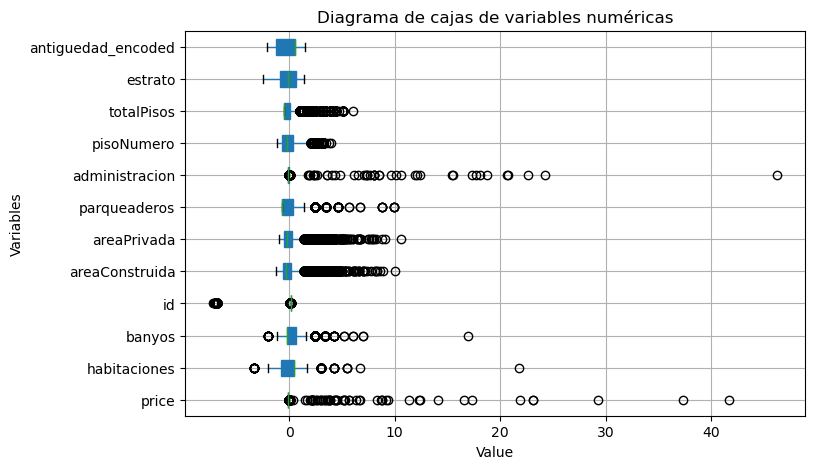

In [8]:
def clasificar_variable(tipo):
    if pd.api.types.is_numeric_dtype(tipo):
        return 'Numérica'
    elif pd.api.types.is_string_dtype(tipo):
        return 'Categórica'
    else:
        return 'Otra'



def create_box(df_):
    numerics = [num for num in df_.columns if clasificar_variable(df_[num].dtype)=='Numérica']
    scaler = StandardScaler()
    # Create a copy of the DataFrame and normalize the selected columns
    df_normalized = df_[numerics].copy()
    df_normalized[numerics] = scaler.fit_transform(df_[numerics])
    # Create the horizontal boxplot
    plt.figure(figsize=(8, 5))
    df_normalized.boxplot(vert=False, patch_artist=True)
    # Set the title, labels, and y-ticks
    plt.title('Diagrama de cajas de variables numéricas')
    plt.xlabel('Value')
    plt.ylabel('Variables')
    plt.yticks(ticks=range(1, len(numerics) + 1), labels=numerics)  # Set labels based on column names
    plt.grid(True)
    plt.show()

create_box(df_nuevo)

## Relaciones entre variables numéricas

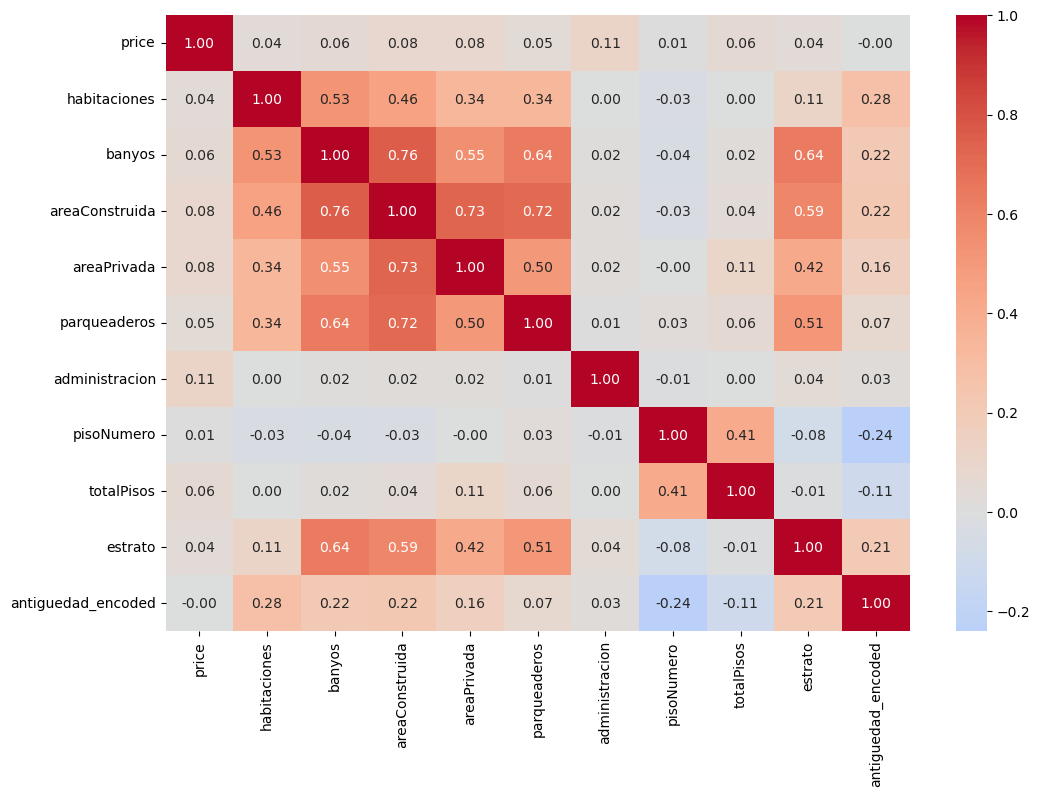

In [9]:
numerics = [num for num in df_nuevo.columns if clasificar_variable(df_nuevo[num].dtype)=='Numérica' and num!="id"]

def corr_matrix(df_):
    # Assuming df_hotels_booking is your DataFrame and 'numerics' is a list of numeric columns
    correlation_matrix = df_.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.show()  # display the heatmap

corr_matrix(df_nuevo[numerics])

# Limpieza de datos

In [10]:
trash_columns = ['descr', 'link','id','date_modified','date_created']
df_nuevo = df.drop(columns=trash_columns)
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7840 entries, 0 to 12624
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               7840 non-null   float64
 1   habitaciones        7836 non-null   float64
 2   banyos              7834 non-null   float64
 3   estadoInmueble      7840 non-null   object 
 4   areaConstruida      7839 non-null   float64
 5   areaPrivada         7322 non-null   float64
 6   antiguedad          7840 non-null   object 
 7   parqueaderos        5617 non-null   float64
 8   administracion      7508 non-null   float64
 9   pisoNumero          7464 non-null   float64
 10  totalPisos          6877 non-null   float64
 11  comodidades         6746 non-null   object 
 12  ubicacion           7840 non-null   object 
 13  estrato             7808 non-null   float64
 14  antiguedad_encoded  7840 non-null   float64
dtypes: float64(11), object(4)
memory usage: 980.0+ KB


In [11]:
print(f"records before cleaning dataframe: {df_nuevo.count()}")
def clean_dataframe(df_):
    # Remove rows with negative values, ignoring NaNs
    for col in columns_to_check:
        df_ = df_[(df_[col] >= 0) | (df_[col].isnull())]

    print(f"Total rows after removing negatives: {df_.shape[0]}")

    # Remove rows where 'estrato' is greater than 6, ignoring NaNs
    df_ = df_[(df_['estrato'] <= 6) | (df_['estrato'].isnull())]

    df_['estadoInmueble'] = df_['estadoInmueble'].replace('¡Pregúntale!', np.nan)
    # Reset the DataFrame index
    df_.reset_index(drop=True, inplace=True)

    return df_

df_cleaned=clean_dataframe(df_nuevo)
print(f"records after cleaning dataframe: {df_cleaned.count()}")

records before cleaning dataframe: price                 7840
habitaciones          7836
banyos                7834
estadoInmueble        7840
areaConstruida        7839
areaPrivada           7322
antiguedad            7840
parqueaderos          5617
administracion        7508
pisoNumero            7464
totalPisos            6877
comodidades           6746
ubicacion             7840
estrato               7808
antiguedad_encoded    7840
dtype: int64
Total rows after removing negatives: 7840
records after cleaning dataframe: price                 7840
habitaciones          7836
banyos                7834
estadoInmueble         509
areaConstruida        7839
areaPrivada           7322
antiguedad            7840
parqueaderos          5617
administracion        7508
pisoNumero            7464
totalPisos            6877
comodidades           6746
ubicacion             7840
estrato               7808
antiguedad_encoded    7840
dtype: int64


In [12]:
df_cleaned.isnull().sum()

price                    0
habitaciones             4
banyos                   6
estadoInmueble        7331
areaConstruida           1
areaPrivada            518
antiguedad               0
parqueaderos          2223
administracion         332
pisoNumero             376
totalPisos             963
comodidades           1094
ubicacion                0
estrato                 32
antiguedad_encoded       0
dtype: int64

In [13]:
(df_cleaned == 0).sum()

price                    0
habitaciones            15
banyos                  14
estadoInmueble           0
areaConstruida           0
areaPrivada           1586
antiguedad               0
parqueaderos             0
administracion         693
pisoNumero             823
totalPisos            4582
comodidades              0
ubicacion                0
estrato                  0
antiguedad_encoded     315
dtype: int64

In [14]:

df_cleaned["banyos"] =df_cleaned["banyos"].replace(0, np.nan)
df_cleaned["habitaciones"] =df_cleaned["habitaciones"].replace(0, np.nan)

df_cleaned = df_cleaned.drop(columns="pisoNumero")
df_cleaned = df_cleaned.drop(columns="totalPisos")

df_cleaned = df_cleaned[df_cleaned['areaPrivada'] != 0] 

In [15]:
df_cleaned["estadoInmueble"].unique()

array(['Excelenteestado', nan, 'Buenestado', 'Nuevo',
       'Requieremantenimiento'], dtype=object)

In [16]:
#df_cleaned["administracion"] = df_cleaned["administracion"].fillna(0)
df_cleaned["parqueaderos"] = df_cleaned["parqueaderos"].fillna(0)
#df_cleaned["habitaciones"] = df_cleaned["habitaciones"].fillna(0)
#df_cleaned["pisoNumero"] = df_cleaned["pisoNumero"].fillna(1)
# df_cleaned["totalPisos"] = df_cleaned["totalPisos"].fillna(1)
# df_cleaned["banyos"] = df_cleaned["banyos"].fillna(0)
df_cleaned["comodidades"] = df_cleaned["comodidades"].fillna("")
df_cleaned["estadoInmueble"] = df_cleaned["estadoInmueble"].fillna("No especificado")
df_cleaned = df_cleaned[df_cleaned['areaPrivada'] > 0] # "No especificado"
df_cleaned = df_cleaned.dropna()

In [274]:
import numpy as np
import pandas as pd

def iqr_skew_adjusted_bounds(series, factor=3.0):
    """
    Returns (lower_bound, upper_bound) for outlier detection
    using an IQR-based rule adjusted by a log-skew factor.
    If Q1 == Q3 == 0, applies a log1p transformation to spread the distribution first.
    """
    print(series.name)
    valid = series.dropna()

    # If series is empty or all identical values
    if valid.nunique() <= 1:
        return (-np.inf, np.inf)

    Q1 = valid.quantile(0.25)
    Q3 = valid.quantile(0.75)

    # Check for flat IQR caused by extreme skew or zero dominance
    if Q1 == 0 and Q3 == 0:
        print(f"Column: {series.name} has Q1 = Q3 = 0, applying log1p transform")
        valid = np.log1p(valid)
        Q1 = valid.quantile(0.25)
        Q3 = valid.quantile(0.75)

    IQR = Q3 - Q1
    mean_val = valid.mean()
    median_val = valid.median()

    # Fallback if median <= 0 or IQR is too small
    if median_val <= 0 or np.isnan(mean_val) or IQR == 0:
        std = valid.std()
        mean_val = valid.mean()
        if np.isnan(std) or std == 0:
            return (-np.inf, np.inf)  # can't calculate anything useful
        print(f"Column: {series.name} — Using mean ± {factor} × std as fallback")
        return (mean_val - factor * std, mean_val + factor * std)

    log_skew_factor = (mean_val / median_val) ** 0.77
    print(f"Column: {series.name}, log skew factor: {log_skew_factor:.3f}, "
          f"mean: {mean_val:.1f}, median: {median_val:.1f}, IQR: {IQR:.3f}, Q1: {Q1:.3f}, Q3: {Q3:.3f}")

    subs_left = factor * IQR * (1 / log_skew_factor) if log_skew_factor != 0 else factor * IQR
    add_right = factor * IQR * log_skew_factor
    lower_bound = Q1 - subs_left
    upper_bound = Q3 + add_right
    print(f"column: {series.name}, lower bound is {lower_bound:.3f}, upper bound is {upper_bound:.3f}, "
          f"subs left: {subs_left:.3f}, add right: {add_right:.3f}")
    return lower_bound, upper_bound


def remove_outliers_iqr_skew_all(df, factor=3.0):
    """
    Applies the iqr_skew_adjusted_bounds to each numeric column in df.
    A row is removed if it is an outlier in ANY numeric column.
    Returns a new DataFrame with those rows removed.
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Start with a mask of all True
    mask = pd.Series(True, index=df.index)
    
    # For each numeric column, compute skew-adjusted IQR bounds, then refine the mask
    for col in numeric_cols:
        lb, ub = iqr_skew_adjusted_bounds(df[col], factor=factor)
        
        # Keep rows that are NaN or within [lb, ub]
        col_mask = df[col].isna() | ((df[col] >= lb) & (df[col] <= ub))
        mask &= col_mask  # logical AND: row must be non-outlier in ALL numeric cols
    
    # Return filtered DataFrame
    return df[mask].reset_index(drop=True)

df_no_outliers = remove_outliers_iqr_skew_all(df_cleaned, factor=4.0)

price
Column: price, log skew factor: 7.820, mean: 6215726152.9, median: 430000000.0, IQR: 491000000.000, Q1: 259000000.000, Q3: 750000000.000
column: price, lower bound is 7855626.757, upper bound is 16108878840.036, subs left: 251144373.243, add right: 15358878840.036
habitaciones
Column: habitaciones, log skew factor: 0.901, mean: 2.6, median: 3.0, IQR: 1.000, Q1: 2.000, Q3: 3.000
column: habitaciones, lower bound is -2.437, upper bound is 6.606, subs left: 4.437, add right: 3.606
banyos
Column: banyos, log skew factor: 1.093, mean: 2.2, median: 2.0, IQR: 1.000, Q1: 2.000, Q3: 3.000
column: banyos, lower bound is -1.659, upper bound is 7.372, subs left: 3.659, add right: 4.372
areaConstruida
Column: areaConstruida, log skew factor: 1.253, mean: 96.9, median: 72.2, IQR: 60.000, Q1: 52.000, Q3: 112.000
column: areaConstruida, lower bound is -139.519, upper bound is 412.754, subs left: 191.519, add right: 300.754
areaPrivada
Column: areaPrivada, log skew factor: 1.250, mean: 94.9, medi

# Análisis descriptivo post-limpieza

## Caracterización general de la muestra

In [276]:
main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion"]
summary = df_no_outliers[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion
count,5253.00,5253.00,5253.00,5253.00,5253.00,5253.00,5253.00,5253.00
mean,617629314.78,2.61,2.21,4.10,92.02,89.95,1.14,510062.59
std,649967509.17,0.74,1.01,1.28,60.53,59.32,0.99,576927.37
min,8500000.00,1.00,1.00,1.00,15.76,2.00,0.00,0.00
25%,255000000.00,2.00,2.00,3.00,52.00,50.38,0.00,140000.00
50%,420000000.00,3.00,2.00,4.00,72.00,71.00,1.00,322000.00
75%,730000000.00,3.00,3.00,5.00,110.00,108.00,2.00,680000.00
max,11500000000.00,6.00,7.00,6.00,404.00,404.00,11.00,6500000.00


•	El mercado presenta una distribución sesgada a la derecha, con algunos inmuebles muy costosos que elevan la media.

•	La mayoría de los inmuebles registrados corresponden a apartamentos con entre 1 y 3 habitaciones y entre 1 y 3 baños, configuraciones que reflejan un mercado dirigido principalmente a viviendas familiares o de gama media, en línea con la estructura típica del mercado inmobiliario de Bogotá

•	Las variables físicas, como habitaciones, baños y parqueaderos, tienden a concentrarse en valores bajos o medios, siendo comunes los inmuebles con no más de 1 parqueadero y con no más de 2 piso



## Calidad de la información

In [277]:
def discrete_variable_summary_without_nulls(df):
    summaries = []
    excluir = ['comodidades', 'date_created', 'date_modified']
    columnas_a_excluir = [col for col in excluir if col in df.columns]
    df_resultado = df.drop(columns=columnas_a_excluir)
    
    total = df.shape[0]  # total de registros incluyendo nulos
    
    for column in df_resultado.columns.tolist():
        # Moda sin nulos
        moda = df[column].mode(dropna=True)[0]
        freq = df[df[column] == moda].shape[0]
        total_no_nulos = df[column].count()
        perc = (freq / total_no_nulos) * 100 if total_no_nulos > 0 else 0

        
        summary = {
            'col': column,
            'uniques': df[column].nunique(),
            'mode': moda,
            'freq': freq,
            'perc': round(perc, 2)
        }
        summaries.append(summary)

    return pd.DataFrame(summaries)

discrete_variable_summary_without_nulls(df_no_outliers)

,col,uniques,mode,freq,perc
0,price,914,650000000.00,65,1.24
1,habitaciones,6,3.00,2950,56.16
2,banyos,7,2.00,2445,46.54
3,estadoInmueble,5,No especificado,4837,92.08
4,areaConstruida,532,60.00,93,1.77
5,areaPrivada,546,50.00,103,1.96
6,antiguedad,6,16 a 30 años,1482,28.21
7,parqueaderos,8,1.00,2015,38.36
8,administracion,1454,0.00,480,9.14
9,ubicacion,587,"Usaquen, Bogotá, Bogotá, d.c.",398,7.58


•	La variable estadoInmueble presenta cerca del 90% de registros no especificados. Esto sugiere que es una característica que frecuentemente no es diligenciada durante el registro de los inmuebles.

•	El estrato más común es el estrato 4 (27.47%), representativo de una oferta orientada a clase media-alta



## Distribución de los datos

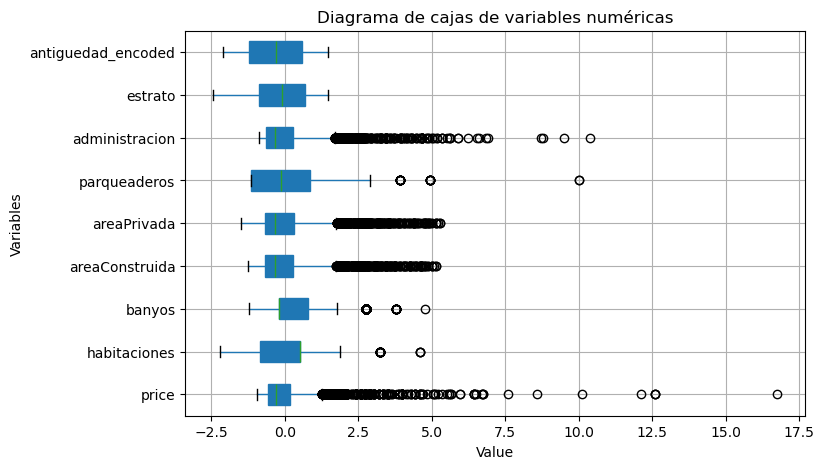

In [278]:
create_box(df_no_outliers)

•	Las variables como baños, habitaciones y estrato presentan una distribución relativamente normal, con mediana cercana a la media y una cantidad equilibrada de valores atípicos en ambos extremos.

•	En contraste, variables como administración, área construida, área privada y precio muestran una alta concentración de valores atípicos, lo cual indica una gran dispersión en estas características y la presencia de inmuebles significativamente distintos al promedio, ya sea por lujo, tamaño o ubicación.


## Principales hallazgos de correlación

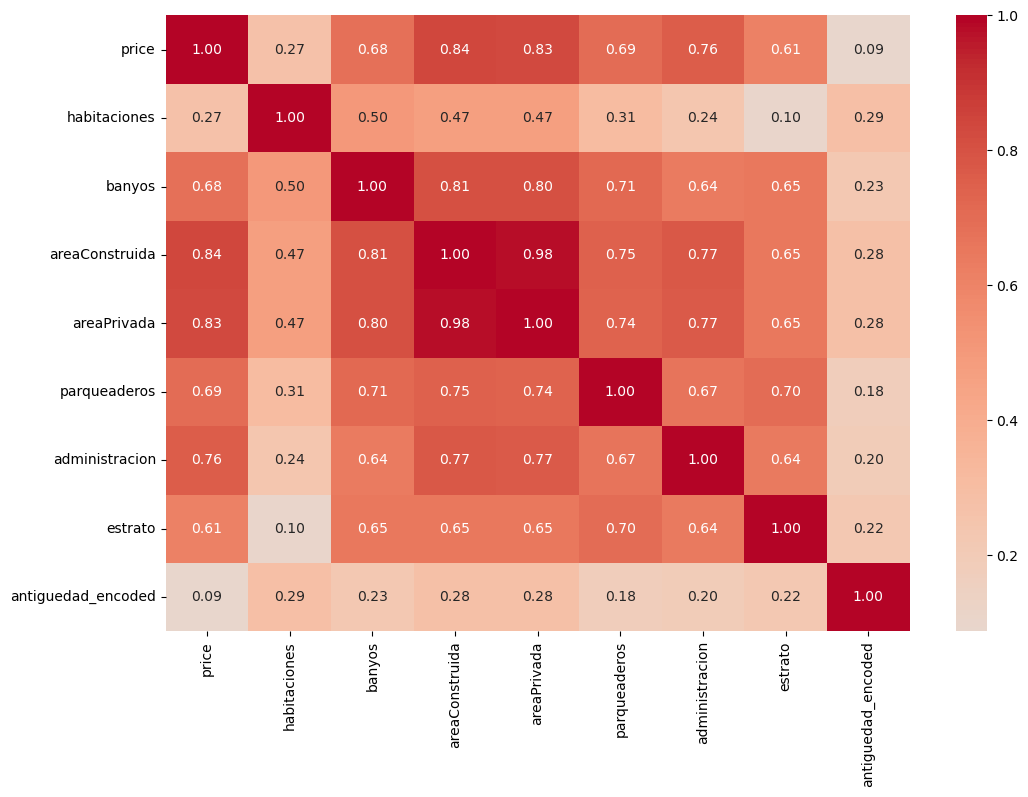

In [279]:

numerics = [num for num in df_no_outliers.columns if clasificar_variable(df_no_outliers[num].dtype)=='Numérica']
corr_matrix(df_no_outliers[numerics])

•	Las variables que más explican el precio de un apartamento son: tamaño (areaConstruida, areaPrivada), comodidades (baños, parqueaderos), costo de administración y estrato socioeconómico. Todas muestran correlaciones fuertes y positivas con la variable price.

•	La variable antiguedad_encoded presentan correlaciones cercanas a cero con el precio, lo que indica que su influencia directa sobre el valor de un inmueble es limitada o poco significativa en este conjunto de datos

•	areaConstruida y areaPrivada mantienen una relación altamente positiva, lo cual es coherente con su naturaleza estructural: el área privada suele representar una porción fija o dominante del área construida.



## limpieza de datos

In [280]:
mapa_antiguedad = {
    "menor a 1 año": 1,
    "1 a 8 años": 2,
    "9 a 15 años": 3,
    "16 a 30 años": 4,
    "más de 30 años": 5,
    "¡Pregúntale!": np.nan  # por ejemplo, puedes marcarlo como NaN
}

df_nuevo["antiguedad"] = df_nuevo["antiguedad"].replace(mapa_antiguedad)
df_nuevo.sample(5)

,price,habitaciones,banyos,estadoInmueble,areaConstruida,areaPrivada,antiguedad,parqueaderos,administracion,pisoNumero,totalPisos,comodidades,ubicacion,estrato,antiguedad_encoded
2179,4500000000.00,3.00,3.00,¡Pregúntale!,317.00,NaN,3.00,3.00,3150000.00,NaN,NaN,•Ascensor•Citófono•Closet•Cocina Integral•Gimn...,"Los rosales, Bogotá, Bogotá, d.c.",5.00,2.00
4068,800000000.00,1.00,2.00,¡Pregúntale!,110.00,NaN,4.00,2.00,893000.00,NaN,NaN,•Calentador•Duplex•Instalación de gas,"Los rosales, Bogotá, Bogotá, d.c.",6.00,3.00
7231,435000000.00,1.00,2.00,¡Pregúntale!,58.00,0.00,3.00,1.00,588700.00,6.00,0.00,•Calentador•Cerca centro comercial•Closet•Coci...,"Santa barbara occidental, Bogotá, Bogotá, d.c.",6.00,2.00
11170,600000000.00,3.00,2.00,Excelenteestado,86.00,86.00,2.00,NaN,610000.00,2.00,0.00,•Acceso Pavimentado•Aire Acondicionado•Alcanta...,"Barrios Unidos, Bogotá, Bogotá, d.c.",3.00,1.00
745,108000000.00,2.00,1.00,¡Pregúntale!,40.00,40.00,2.00,NaN,NaN,NaN,NaN,None,"Alfonso López -Usme, Bogotá, Bogotá, d.c.",2.00,1.00


In [281]:
# Reemplazar NaN con cadena vacía para evitar problemas
df_no_outliers['comodidades'] = df_no_outliers['comodidades'].fillna('')

# Generar las columnas de comodidades (multi-hot encoding)
df_comodidades = df_no_outliers['comodidades'].str.get_dummies(sep='•')

# Unir al DataFrame original
df_final = df_no_outliers.join(df_comodidades)
df_final = df_final.drop(columns=["comodidades"])
df_final.columns

Index(['price', 'habitaciones', 'banyos', 'estadoInmueble', 'areaConstruida',
       'areaPrivada', 'antiguedad', 'parqueaderos', 'administracion',
       'ubicacion',
       ...
       'Zona Comercial', 'Zona Industrial', 'Zona Infantil',
       'Zona Residencial', 'Zona de BBQ', 'Zona de lavandería', 'Zonas Verdes',
       'Árboles frutales', 'Área Rural', 'Área Urbana'],
      dtype='object', length=168)

In [282]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Reemplazar cadenas vacías
df_final = df_final.replace('', np.nan)

In [283]:
dummy_columns =["estadoInmueble", "ubicacion"]
df_encoded = pd.get_dummies(
    df_final,
    columns=dummy_columns
    #,drop_first=True  # This will drop the first category, preventing unnecessary columns
)

df_encoded.columns

Index(['price', 'habitaciones', 'banyos', 'areaConstruida', 'areaPrivada',
       'antiguedad', 'parqueaderos', 'administracion', 'estrato',
       'antiguedad_encoded',
       ...
       'ubicacion_Walessa, Bogotá, Bogotá, d.c.',
       'ubicacion_Yerbabuena, Bogotá, Bogotá, d.c.',
       'ubicacion_Zarzamora, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona Noroccidente, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona centro, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona chapinero, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona industrial, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona norte, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona occidental, Bogotá, Bogotá, d.c.',
       'ubicacion_Zona sur, Bogotá, Bogotá, d.c.'],
      dtype='object', length=758)

In [284]:
# Show count and percentage of nulls per column
nulls = df_encoded.isnull().sum().to_frame(name='null_count')
nulls['null_percentage'] = 100 * nulls['null_count'] / len(df)

print(nulls[nulls['null_count']>0])

Empty DataFrame
Columns: [null_count, null_percentage]
Index: []


In [285]:

if "antiguedad" in df_encoded.columns:
    df_encoded=df_encoded.drop(columns=["antiguedad"])
new_main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","antiguedad_encoded"]

## Visualización exploratoria de las variables

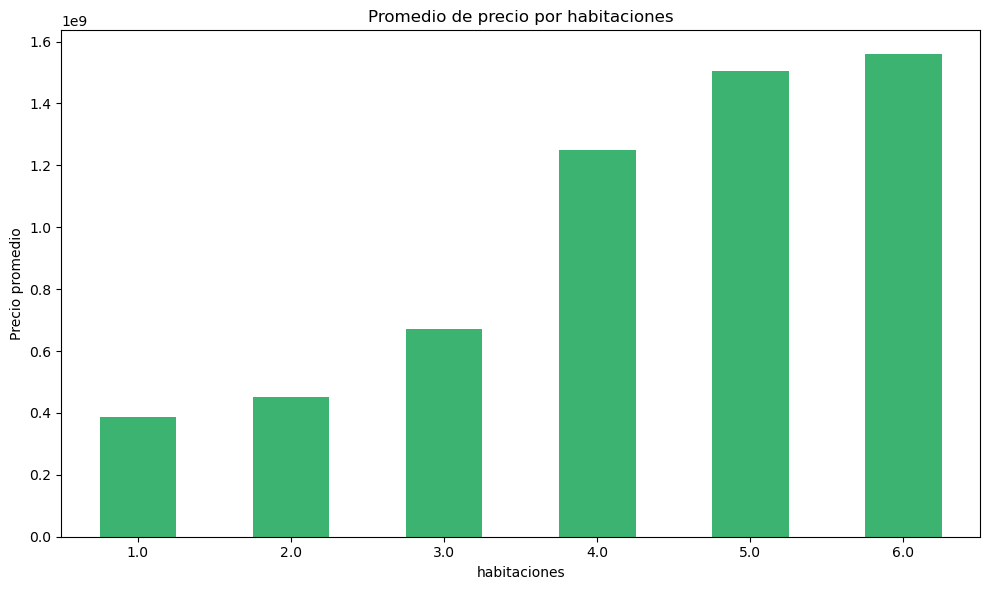

In [286]:
import matplotlib.pyplot as plt
def average_price_by_category(df_, col):
    promedio_por_habitaciones = df_.groupby(col)["price"].mean().sort_index()
    promedio_por_habitaciones.plot(kind="bar", figsize=(10, 6), color="mediumseagreen")
    plt.title(f"Promedio de precio por {col}")
    plt.xlabel(col)
    plt.ylabel("Precio promedio")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

average_price_by_category(df_no_outliers, "habitaciones")

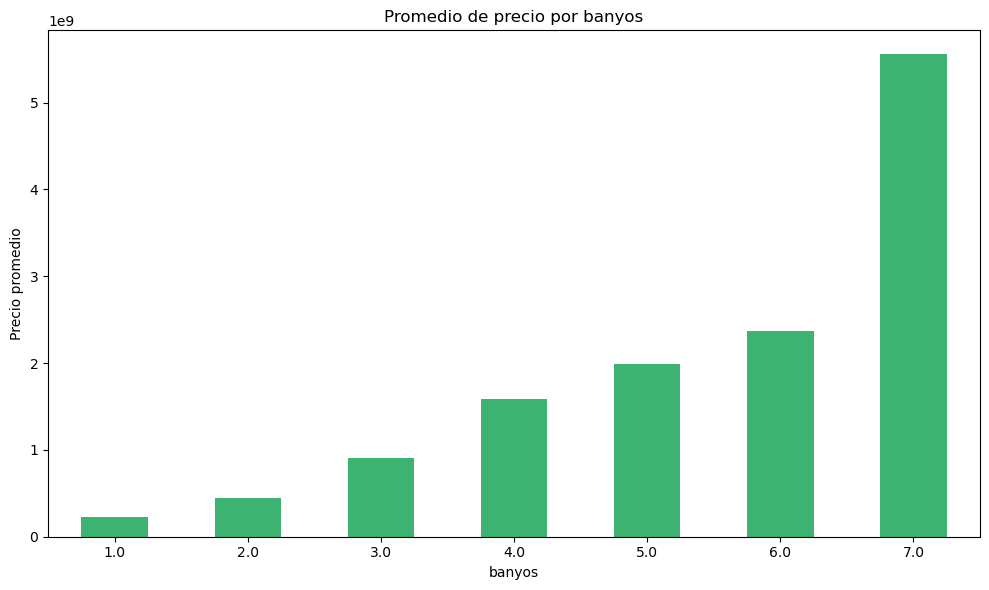

In [287]:
average_price_by_category(df_no_outliers, "banyos")

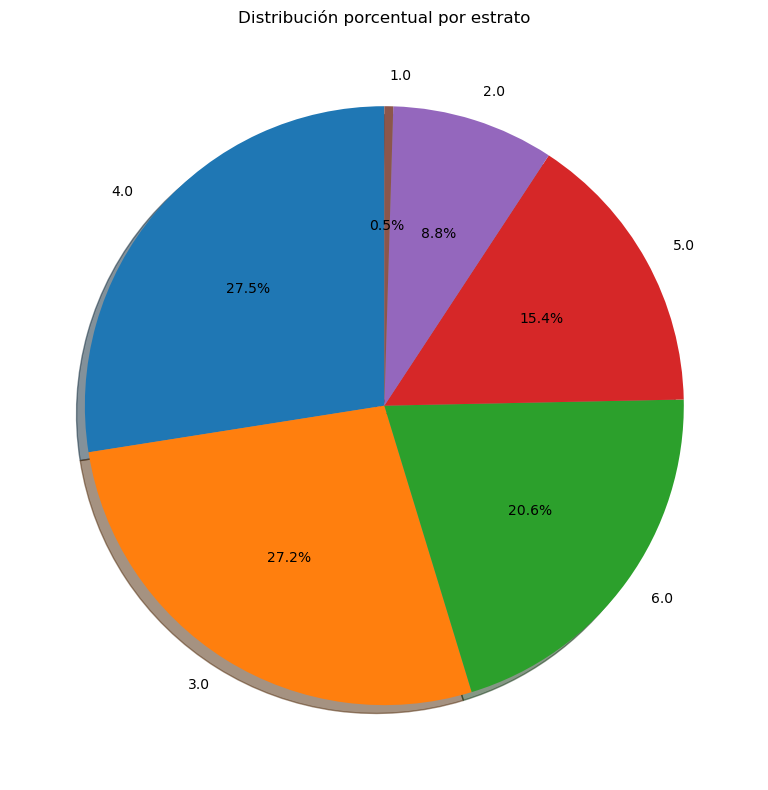

In [288]:
# Suponiendo que tu dataframe se llama df y tiene la columna 'estrato'
# Contar la cantidad de inmuebles por estrato
df_no_outliers = df_no_outliers.dropna()

def bar_plot(df_,variable):
    # Crear el barplot
    conteo_estrato = df_[variable].value_counts().sort_index()
    plt.figure(figsize=(8,5))
    sns.barplot(x=conteo_estrato.index, y=conteo_estrato.values)
    # Etiquetas y título
    plt.xlabel(variable)
    plt.ylabel('Número de inmuebles')
    plt.title(f'Distribución de inmuebles por {variable}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Mostrar gráfico
    plt.show()

def pie_chart_by_category(df_, col):
    conteo = df_[col].value_counts()
    conteo.plot(
        kind='pie',
        figsize=(8, 8),
        autopct='%1.1f%%',
        startangle=90,
        shadow=True
    )
    plt.title(f"Distribución porcentual por {col}")
    plt.ylabel("")  # Quita etiqueta vertical
    plt.tight_layout()
    plt.show()

pie_chart_by_category(df_no_outliers, "estrato")

En la Figura se presenta la distribución de inmuebles según el estrato socioeconómico. Los estratos 3 y 4 concentran la mayor cantidad de inmuebles, con más de 27% de registros cada uno. Esto refleja que la oferta en el mercado inmobiliario está dominada por propiedades de nivel socioeconómico medio.

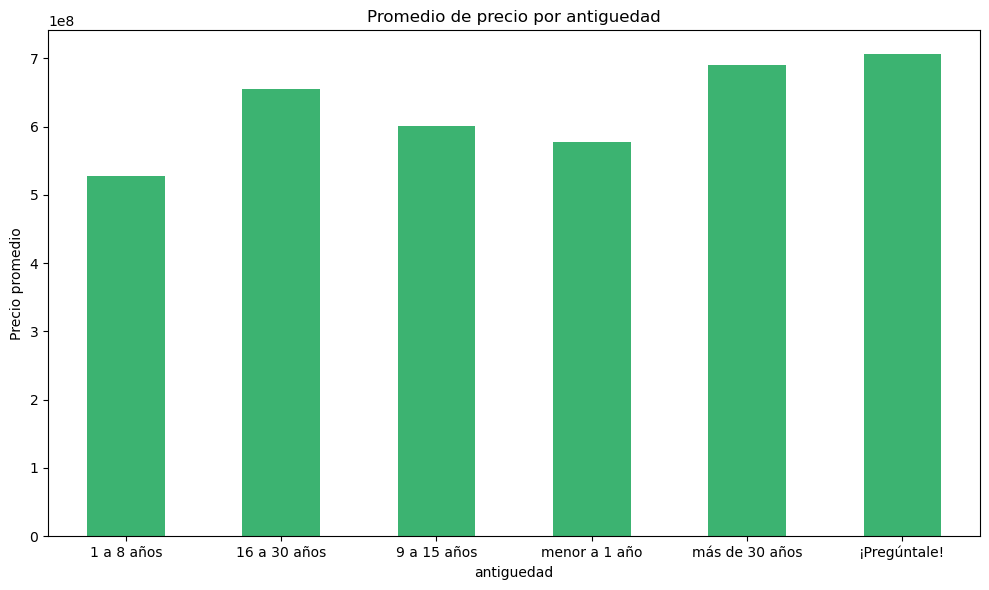

In [289]:
average_price_by_category(df_no_outliers, "antiguedad")

La variable antigüedad no muestra una relación lineal directa con el precio promedio. Si bien los inmuebles más antiguos (más de 30 años) y los no especificados (¡Pregúntale!) presentan los precios más altos, los apartamentos más nuevos no necesariamente lideran en valor. Esto sugiere que la antigüedad, por sí sola, no es un buen predictor del precio sin considerar otras variables como ubicación, tamaño y estrato. Se recomienda revisar o eliminar la categoría ¡Pregúntale! por tratarse de un valor posiblemente erróneo o no informativo.


<function matplotlib.pyplot.show(close=None, block=None)>

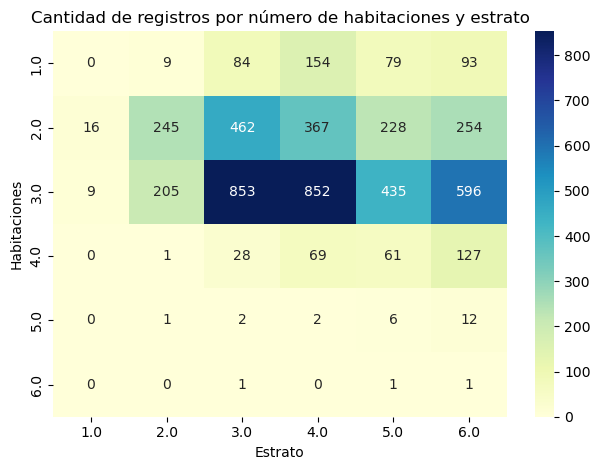

In [290]:
def scatter_plot(df, col_x, col_y):
    """
    Genera un scatter plot entre dos columnas de un dataframe.

    Parámetros:
    - df: dataframe que contiene los datos
    - col_x: nombre de la columna para el eje X (string)
    - col_y: nombre de la columna para el eje Y (string)
    """
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x=col_x, y=col_y, alpha=0.6, edgecolor=None)

    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(f"Relación entre {col_x} y {col_y}")
    plt.tight_layout()
    plt.show()

import seaborn as sns
import pandas as pd

# Crear tabla de frecuencia cruzada
tabla = pd.crosstab(df_no_outliers['habitaciones'], df_no_outliers['estrato'])

# Graficar heatmap
sns.heatmap(tabla, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Cantidad de registros por número de habitaciones y estrato")
plt.xlabel("Estrato")
plt.ylabel("Habitaciones")
plt.tight_layout()
plt.show


Las combinaciones más frecuentes corresponden a apartamentos de 3 habitaciones ubicados en estratos 3 y 4, cada una con más de 850 registros. No se observa una relación lineal directa entre el número de habitaciones y el estrato; por el contrario, los valores se concentran principalmente en los niveles medios de ambas variables.


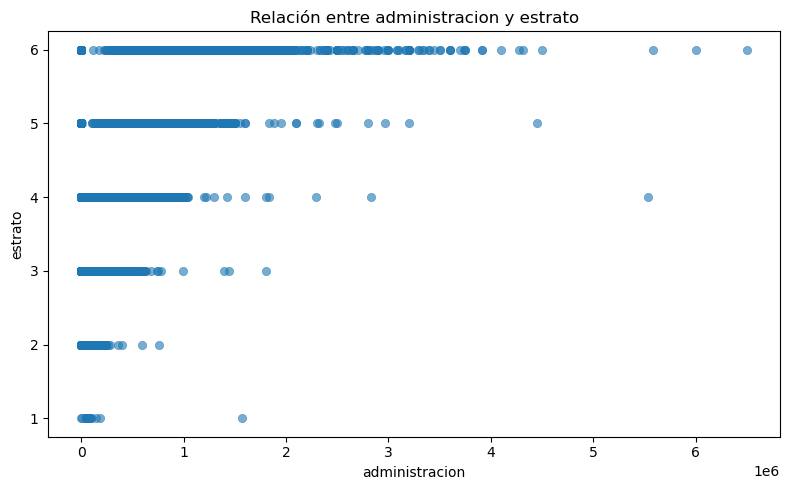

In [291]:
scatter_plot(df_no_outliers,"administracion","estrato")

En la Figura se presenta la relación entre el valor de la cuota de administración y el estrato socioeconómico de los inmuebles. Se observa una clara tendencia en la que los inmuebles de estratos altos (especialmente 5 y 6) concentran las cuotas de administración más elevadas, mientras que en los estratos bajos (1 y 2) las cuotas de administración son considerablemente menores. Esta relación es consistente con las dinámicas típicas del mercado inmobiliario de Bogotá, donde las propiedades de estratos superiores suelen ofrecer más y mejores servicios comunales, lo que incrementa los costos asociados. 
No obstante, también se identifican algunos valores atípicos, como inmuebles de estratos bajos con cuotas de administración elevadas, lo que podría atribuirse a errores de registro o casos excepcionales como edificaciones con servicios premium ubicadas en sectores tradicionales. Esta visualización refuerza la correlación positiva previamente identificada entre estrato y administracion


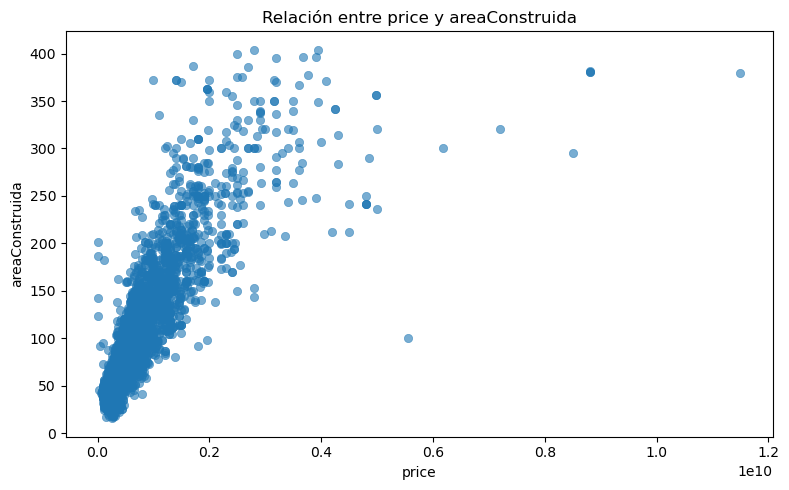

In [338]:
scatter_plot(df_no_outliers,"price","areaConstruida")

La relación entre areaPrivada y price es claramente positiva, lo que confirma que el tamaño del apartamento es uno de los factores determinantes del valor de venta. Sin embargo, también se evidencia una dispersión importante a medida que aumenta el área, indicando que otras variables como ubicación, estrato o estado del inmueble influyen considerablemente en el precio final.

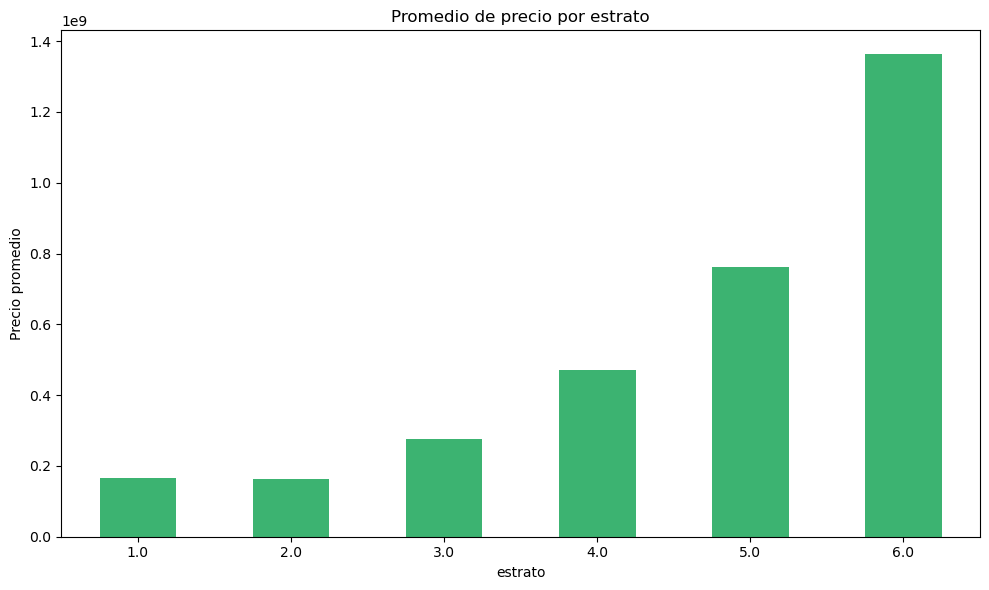

In [293]:
average_price_by_category(df_no_outliers, "estrato")

El gráfico confirma que el precio promedio de los apartamentos se incrementa de forma constante con el estrato socioeconómico. Este comportamiento es consistente con la segmentación urbana de Bogotá, donde los estratos más altos concentran inmuebles más amplios, modernos o mejor ubicados. Dado su fuerte asociación con el precio, la variable estrato debe ser considerada como uno de los factores clave en el modelado predictivo.a


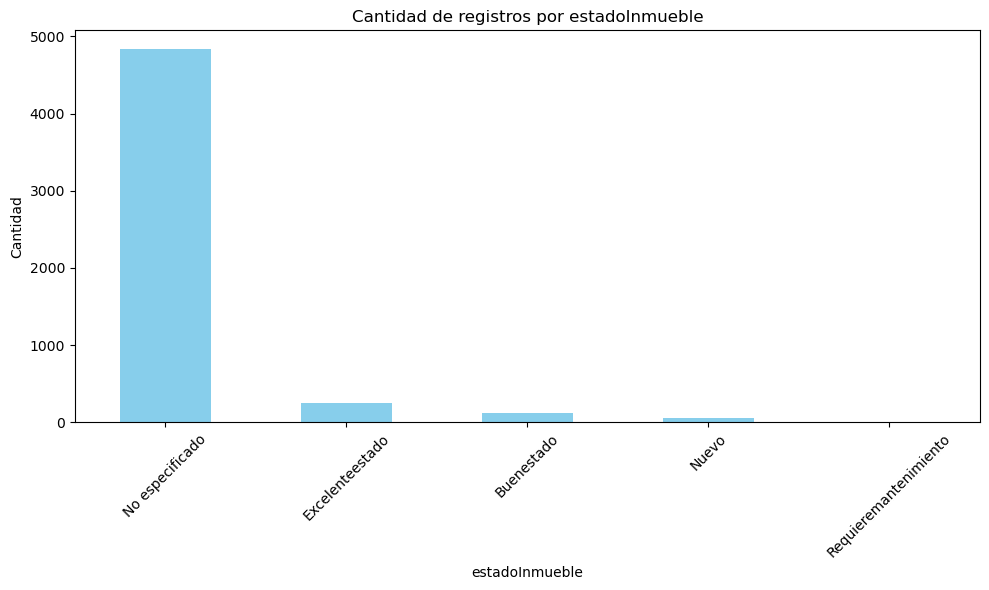

In [294]:
def rows_by_category(df_, col):
    conteo = df_[col].value_counts()
    conteo.plot(kind='bar', figsize=(10, 6), color='skyblue')
    plt.title(f"Cantidad de registros por {col}")
    plt.xlabel(col)
    plt.ylabel("Cantidad")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Uso:
rows_by_category(df_no_outliers, "estadoInmueble")


La variable estadoInmueble presenta una distribución altamente desbalanceada, donde la categoría “No especificado” representa la gran mayoría de los registros. Las demás categorías 
están poco representadas, lo que limita su utilidad tanto para análisis descriptivos como para modelos predictivos. 


## modelo de machine learning para predecir precio

### Modelo de regresión lineal

In [295]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance

scaler = MinMaxScaler()
numeric_cols = df_encoded.select_dtypes(include=["int64", "float64"]).columns
df_scaled = df_encoded.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

def permu_importance(model_, X_test, y_test):
    result = permutation_importance(model_, X_test, y_test, n_repeats=10, random_state=42)
    importance_df = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean
    }).sort_values(by="Importance", ascending=False)
    importance_df["Importance"] = importance_df["Importance"] / importance_df["Importance"].sum()
    print(importance_df[["Feature", "Importance"]])

def feature_importance(model_, X):
    # After model.fit(...)
    importances = model_.feature_importances_
    # Assuming X is a DataFrame, get feature names
    feature_names = X.columns
    # Create a sorted DataFrame of importances
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    print(importance_df)


def calcular_medape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Crear máscara para evitar divisiones por cero
    mask = y_true != 0
    y_true_filtrado = y_true[mask]
    y_pred_filtrado = y_pred[mask]
    
    mape = np.mean(np.abs((y_true_filtrado - y_pred_filtrado) / y_true_filtrado)) * 100
    print(f"MAPE: {mape:.2f}%")
    medape = np.median(np.abs((y_true_filtrado - y_pred_filtrado) / y_true_filtrado)) * 100
    print(f"MEDAPE: {medape:.2f}%")



def linear_regression(df_):
    # 🎯 1. Define features (X) and target (y)
    numeric_cols = df_.select_dtypes(include=["int64", "float64"]).columns
    X = df_.drop(columns=["price"])
    y = df_["price"]
    # ✂️ 2. Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # 🤖 4. Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # 📈 5. Predict and evaluate
    y_pred = model.predict(X_test)
    calcular_medape(y_test, y_pred)
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
    print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred, squared=False))
    print("R^2 Score:", r2_score(y_test, y_pred))
    return X_train, X_test, y_train, y_test, y_pred, model

X_train, X_test, y_train, y_test, y_pred, model = linear_regression(df_scaled)

MAPE: 245422448592.67%
MEDAPE: 25.61%
Mean Absolute Error (MAE): 61202406.98428423
Root Mean Squared Error (RMSE): 707816340.1763338
R^2 Score: -1.7550949622485202e+20


In [296]:
import pandas as pd

# Crear un DataFrame con reales y predicciones
comparacion = pd.DataFrame({
    "valor_real": y_test.values,
    "prediccion": y_pred
})

# Mostrar 10 muestras aleatorias
print(comparacion.sample(20, random_state=42))

      valor_real    prediccion
352         0.10          0.11
689         0.02          0.02
485         0.10          0.10
388         0.02          0.02
31          0.01 1043744184.10
442         0.03          0.02
198         0.04          0.03
425         0.04          0.05
107         0.02          0.02
714         0.12          0.23
552         0.01          0.01
675         0.06          0.06
158         0.31          0.26
475         0.02          0.02
423         0.04          0.01
1025        0.07          0.09
617         0.03  278861227.71
483         0.17          0.21
864         0.01          0.01
650         0.12          0.13


In [324]:
df_scaled_no_comodidades = df_scaled.copy()
print(f"total columns before removing commodities is: {df_scaled_no_comodidades.shape[1]}")
for col in df_comodidades.columns:
    if col in df_scaled_no_comodidades.columns:
        df_scaled_no_comodidades = df_scaled_no_comodidades.drop(columns=[col])
df_scaled_no_comodidades = df_scaled_no_comodidades.loc[:, ~df_scaled_no_comodidades.columns.str.startswith("ubicacion_")]
print(f"total columns after removing commodities is: {df_scaled_no_comodidades.shape[1]}")
X_train, X_test, y_train, y_test, y_pred, model = linear_regression(df_scaled_no_comodidades)

import matplotlib.pyplot as plt
import numpy as np

def scatterplot_prediccion_error(y_test_, y_pred_):
    mask = y_test != 0
    error_pct = np.abs((y_test_[mask] - y_pred_[mask]) / y_test_[mask])
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test_[mask], error_pct, alpha=0.6, color="cornflowerblue")
    plt.title("Error relativo vs. precio real")
    plt.xlabel("Precio real (valor observado)")
    plt.ylabel("Error relativo")
    plt.grid(True)
    plt.tight_layout()
    plt.yscale("log") # evitar que la gráfica se distorsione por algunos errores extremos
    plt.show()


def scatterplot_real_vs_predicho(y_test_, y_pred_):
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test_, y_pred_, alpha=0.6, color="mediumseagreen")
    plt.plot([y_test_.min(), y_test_.max()], [y_test_.min(), y_test_.max()], 'r--', label="Referencia perfecta")
    plt.title("Precio real vs. Precio predicho")
    plt.xlabel("Precio real (valor observado)")
    plt.ylabel("Precio predicho (modelo)")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

total columns before removing commodities is: 757
total columns after removing commodities is: 14
MAPE: 28.95%
MEDAPE: 20.60%
Mean Absolute Error (MAE): 0.012312018532817413
Root Mean Squared Error (RMSE): 0.020799956392957803
R^2 Score: 0.8484401034821651


MAPE: 28.59%
MEDAPE: 21.00%
Mean Absolute Error (MAE): 0.012234973608052856
Root Mean Squared Error (RMSE): 0.020729826853894875
R^2 Score: 0.8494603851889788


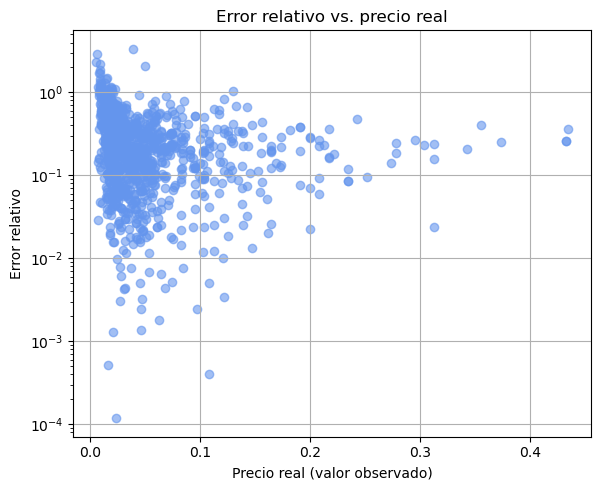

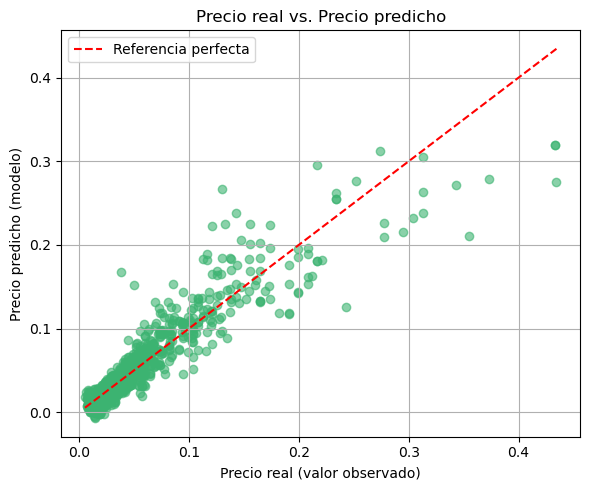

              Feature  Importance
3      areaConstruida        0.59
6      administracion        0.18
4         areaPrivada        0.13
7  antiguedad_encoded        0.06
0        habitaciones        0.03
5        parqueaderos        0.01
2             estrato        0.00
1              banyos       -0.00


In [325]:
X_train, X_test, y_train, y_test, y_pred, model = linear_regression(df_scaled[new_main_columns])
scatterplot_prediccion_error(y_test, y_pred)
scatterplot_real_vs_predicho(y_test, y_pred)
# Llamada a la función
permu_importance(model, X_test, y_test)

### modelo de regresión random forest

In [299]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def random_forest_regressor(df_):
    # Separar variables
    print(f"total columns are: {df_.shape[1]}")
    X = df_.drop(columns=["price"])
    y = df_["price"]
    # Dividir en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Modelo
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(X_train, y_train)
    # Predicción
    y_pred = rf_reg.predict(X_test)
    # Evaluación
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    calcular_medape(y_test, y_pred)
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    return y_test, y_pred, rf_reg, X

y_test, y_pred, model, X = random_forest_regressor(df_scaled)

total columns are: 757
MAPE: 13.13%
MEDAPE: 9.26%
MAE: 0.0079
RMSE: 0.0164
R² Score: 0.9057


In [326]:
y_test, y_pred, model, X = random_forest_regressor(df_scaled[new_main_columns])

total columns are: 9
MAPE: 13.42%
MEDAPE: 8.99%
MAE: 0.0079
RMSE: 0.0168
R² Score: 0.9007


total columns are: 14
MAPE: 13.25%
MEDAPE: 8.80%
MAE: 0.0078
RMSE: 0.0164
R² Score: 0.9058


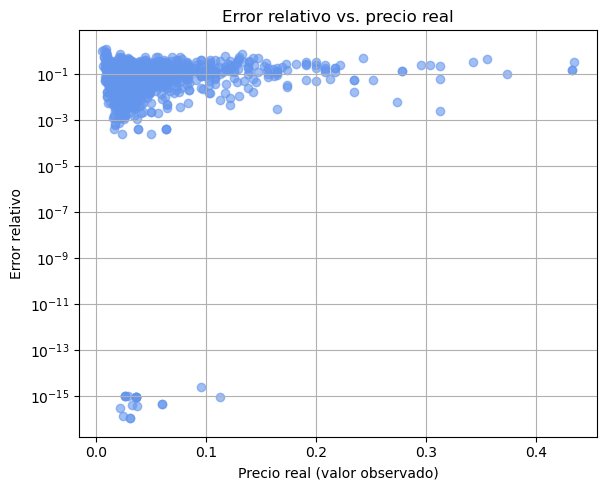

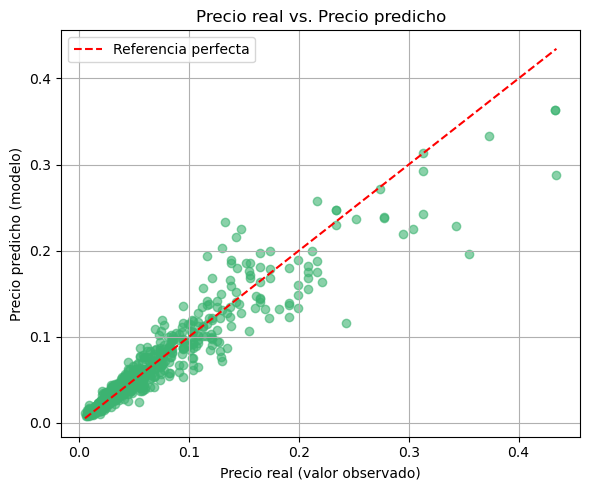

                                 Feature  Importance
2                         areaConstruida        0.59
3                            areaPrivada        0.15
7                     antiguedad_encoded        0.09
5                         administracion        0.08
6                                estrato        0.02
4                           parqueaderos        0.02
11                  estadoInmueble_Nuevo        0.01
1                                 banyos        0.01
0                           habitaciones        0.01
10        estadoInmueble_No especificado        0.00
9         estadoInmueble_Excelenteestado        0.00
8              estadoInmueble_Buenestado        0.00
12  estadoInmueble_Requieremantenimiento        0.00


In [327]:
y_test, y_pred, model, X = random_forest_regressor(df_scaled_no_comodidades)
scatterplot_prediccion_error(y_test, y_pred)
scatterplot_real_vs_predicho(y_test, y_pred)
feature_importance(model, X)

### Modelo de clasificación random forest

In [337]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df_scaled_with_range_price = df_scaled.copy()
df_scaled_with_range_price["range_price"] = pd.qcut(df_scaled["price"], q=7, labels=False) + 1

if "price" in df_scaled_with_range_price.columns:
    df_scaled_with_range_price=df_scaled_with_range_price.drop(columns=["price"])
df_scaled_with_range_price["range_price"] = df_scaled_with_range_price["range_price"].astype(int)

# Obtener los bins de los cuantiles
bins = pd.qcut(df_scaled["price"], q=7, retbins=True)[1]

# Crear la tabla
range_data = []
for i in range(len(bins) - 1):
    rango = f"Rango {i+1}"
    minimo = round(bins[i], 4)
    maximo = round(bins[i+1], 4)
    amplitud = round(maximo - minimo, 4)
    range_data.append([rango,f"{minimo:.4f}",f"{maximo:.4f}",f"{amplitud:.4f}"])

# Convertir en DataFrame
price_range_table = pd.DataFrame(range_data, columns=["Rango", "Mínimo", "Máximo", "Amplitud"])
print(price_range_table)

     Rango  Mínimo  Máximo Amplitud
0  Rango 1  0.0000  0.0168   0.0168
1  Rango 2  0.0168  0.0235   0.0067
2  Rango 3  0.0235  0.0315   0.0080
3  Rango 4  0.0315  0.0410   0.0095
4  Rango 5  0.0410  0.0558   0.0148
5  Rango 6  0.0558  0.0932   0.0374
6  Rango 7  0.0932  1.0000   0.9068


In [303]:


new_range_price_columns=["range_price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","antiguedad_encoded"]

def train_random_forest_classifier(df, target_column="range_price", test_size=0.2, random_state=42):
    # Separar variables
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Modelo
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    rf_clf.fit(X_train, y_train)

    # Predicción
    y_pred = rf_clf.predict(X_test)

    return y_test, y_pred, rf_clf, X_test

y_test, y_pred, model, X_test = train_random_forest_classifier(df_scaled_with_range_price)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def accuracy_classification(y_test_, y_pred_):
    print(f"Accuracy: {accuracy_score(y_test_, y_pred_):.4f}")
    print("Classification Report:\n", classification_report(y_test_, y_pred_))

def heatmap_confusion_matrix(y_test_, y_pred_):
    cm = confusion_matrix(y_test_, y_pred_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(1, cm.shape[0] + 1),
            yticklabels=range(1, cm.shape[0] + 1))
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.tight_layout()
    plt.show()

accuracy_classification(y_test, y_pred)

Accuracy: 0.6660
Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.85      0.79       143
           2       0.60      0.60      0.60       162
           3       0.64      0.58      0.61       167
           4       0.52      0.57      0.54       143
           5       0.66      0.57      0.61       154
           6       0.65      0.66      0.65       137
           7       0.87      0.86      0.86       145

    accuracy                           0.67      1051
   macro avg       0.67      0.67      0.67      1051
weighted avg       0.67      0.67      0.67      1051



total columns before removing commodities is: 757
total columns after removing commodities is: 14
Accuracy: 0.7250
Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.91      0.85       143
           2       0.73      0.70      0.72       162
           3       0.73      0.68      0.71       167
           4       0.61      0.64      0.62       143
           5       0.64      0.65      0.65       154
           6       0.69      0.61      0.65       137
           7       0.86      0.90      0.88       145

    accuracy                           0.73      1051
   macro avg       0.72      0.73      0.72      1051
weighted avg       0.72      0.73      0.72      1051



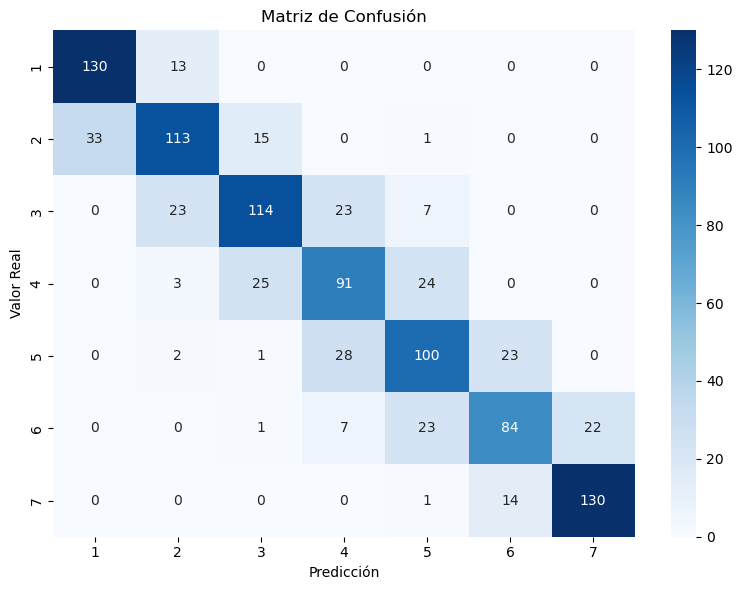

Accuracy: 0.7307
Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.92      0.86       143
           2       0.73      0.71      0.72       162
           3       0.73      0.68      0.70       167
           4       0.63      0.62      0.62       143
           5       0.66      0.66      0.66       154
           6       0.69      0.66      0.67       137
           7       0.85      0.88      0.87       145

    accuracy                           0.73      1051
   macro avg       0.73      0.73      0.73      1051
weighted avg       0.73      0.73      0.73      1051



In [304]:
df_scaled_no_comodidades_with_range_price = df_scaled_with_range_price.copy()
print(f"total columns before removing commodities is: {df_scaled_no_comodidades_with_range_price.shape[1]}")
for col in df_comodidades.columns:
    if col in df_scaled_no_comodidades_with_range_price.columns:
        df_scaled_no_comodidades_with_range_price = df_scaled_no_comodidades_with_range_price.drop(columns=[col])
df_scaled_no_comodidades_with_range_price = df_scaled_no_comodidades_with_range_price.loc[:, ~df_scaled_no_comodidades_with_range_price.columns.str.startswith("ubicacion_")]
print(f"total columns after removing commodities is: {df_scaled_no_comodidades_with_range_price.shape[1]}")
y_test, y_pred, model, X_test = train_random_forest_classifier(df_scaled_no_comodidades_with_range_price)
accuracy_classification(y_test, y_pred)
heatmap_confusion_matrix(y_test, y_pred)
y_test, y_pred, model, X_test = train_random_forest_classifier(df_scaled_with_range_price[new_range_price_columns])
accuracy_classification(y_test, y_pred)

### Modelo de regresión gradient boost

MAPE: 14.99%
MEDAPE: 11.34%
MAE: 0.0080
RMSE: 0.0156
R² Score: 0.9148


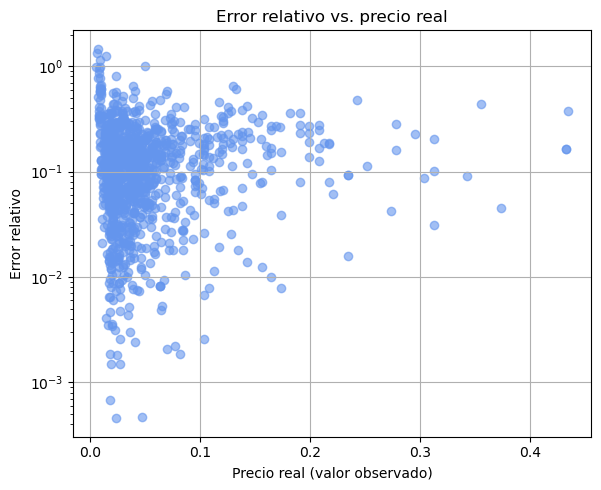

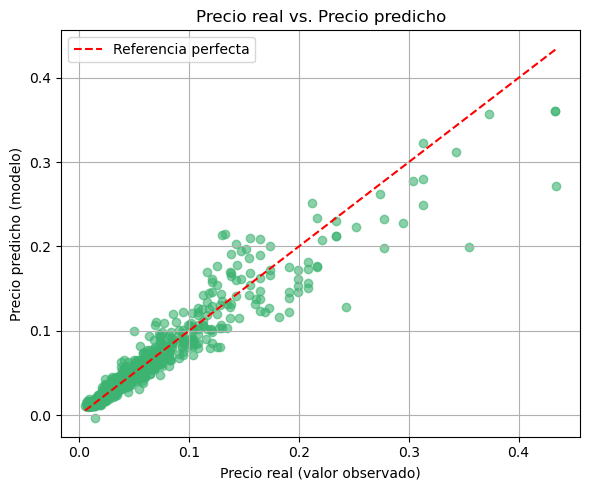

                                       Feature  Importance
2                               areaConstruida        0.58
3                                  areaPrivada        0.13
7                           antiguedad_encoded        0.09
5                               administracion        0.06
4                                 parqueaderos        0.03
..                                         ...         ...
330  ubicacion_El Recodo, Bogotá, Bogotá, d.c.        0.00
331   ubicacion_El Tunal, Bogotá, Bogotá, d.c.        0.00
333  ubicacion_El carmen, Bogotá, Bogotá, d.c.        0.00
334        ubicacion_El castillo, Bogotá, d.c.        0.00
755   ubicacion_Zona sur, Bogotá, Bogotá, d.c.        0.00

[756 rows x 2 columns]


In [330]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def gradient_boost_regressor(df_):
    X = df_.drop(columns=["price"])
    y = df_["price"]  # Suponiendo precio real
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    gb_reg.fit(X_train, y_train)
    y_pred = gb_reg.predict(X_test)
    calcular_medape(y_test, y_pred)
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
    return y_test, y_pred, gb_reg, X

y_test, y_pred,model,X=gradient_boost_regressor(df_scaled)
scatterplot_prediccion_error(y_test, y_pred)
scatterplot_real_vs_predicho(y_test, y_pred)
feature_importance(model, X)

In [331]:
y_test, y_pred, model, X =gradient_boost_regressor(df_scaled[new_main_columns])

MAPE: 15.49%
MEDAPE: 11.93%
MAE: 0.0086
RMSE: 0.0174
R² Score: 0.8944


In [332]:
y_test, y_pred, model, X =gradient_boost_regressor(df_scaled_no_comodidades)


MAPE: 15.37%
MEDAPE: 11.67%
MAE: 0.0083
RMSE: 0.0166
R² Score: 0.9038


### Modelo de clasificación gradient boost

In [335]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_gradient_boost_classifier(df, target_column="range_price", test_size=0.2, random_state=42):
    # Separar variables
    X = df.drop(columns=[target_column])
    y = df[target_column].astype(int)  # Asegurar que los valores sean enteros

    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Modelo
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=random_state)
    gb_clf.fit(X_train, y_train)

    # Predicción
    y_pred = gb_clf.predict(X_test)

    return y_test, y_pred, gb_clf, X_test

y_test, y_pred, model, X_test = train_gradient_boost_classifier(df_scaled_with_range_price)

Accuracy: 0.7060
Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.89      0.85       143
           2       0.74      0.73      0.73       162
           3       0.70      0.64      0.67       167
           4       0.58      0.60      0.59       143
           5       0.64      0.62      0.63       154
           6       0.61      0.62      0.62       137
           7       0.84      0.85      0.85       145

    accuracy                           0.71      1051
   macro avg       0.70      0.71      0.71      1051
weighted avg       0.71      0.71      0.70      1051

Accuracy: 0.7060
Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.89      0.85       143
           2       0.74      0.73      0.73       162
           3       0.70      0.64      0.67       167
           4       0.58      0.60      0.59       143
           5       0.64      0.62      0.63       

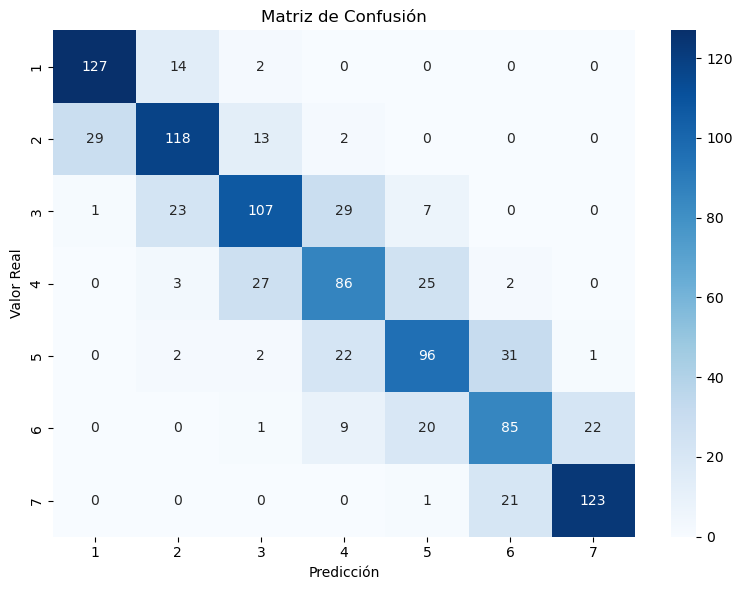

Accuracy: 0.7050
Classification Report:
               precision    recall  f1-score   support

           1       0.83      0.92      0.87       143
           2       0.76      0.75      0.75       162
           3       0.69      0.63      0.66       167
           4       0.55      0.57      0.56       143
           5       0.63      0.60      0.62       154
           6       0.61      0.63      0.62       137
           7       0.85      0.85      0.85       145

    accuracy                           0.71      1051
   macro avg       0.70      0.71      0.70      1051
weighted avg       0.70      0.71      0.70      1051



In [336]:
y_test, y_pred, model, X_test = train_gradient_boost_classifier(df_scaled_no_comodidades_with_range_price)
accuracy_classification(y_test, y_pred)
accuracy_classification(y_test, y_pred)
heatmap_confusion_matrix(y_test, y_pred)
y_test, y_pred, model, X_test = train_gradient_boost_classifier(df_scaled_with_range_price[new_range_price_columns])
accuracy_classification(y_test, y_pred)

### Modelo de clasificación decision tree

In [310]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree_classifier(df, target_column="range_price", test_size=0.2, random_state=42, max_depth=5):
    # Separar variables
    X = df.drop(columns=[target_column])
    y = df[target_column].astype(int)

    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Modelo
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    # Predicción
    y_pred = model.predict(X_test)

    return y_test, y_pred

y_test, y_pred = train_decision_tree_classifier(df_scaled_with_range_price)
accuracy_classification(y_test, y_pred)

Accuracy: 0.5766
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.78      0.74       143
           2       0.54      0.63      0.58       162
           3       0.51      0.47      0.49       167
           4       0.43      0.48      0.45       143
           5       0.52      0.35      0.42       154
           6       0.51      0.58      0.54       137
           7       0.88      0.77      0.82       145

    accuracy                           0.58      1051
   macro avg       0.58      0.58      0.58      1051
weighted avg       0.58      0.58      0.57      1051



Accuracy: 0.5852
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.78      0.74       143
           2       0.54      0.63      0.58       162
           3       0.51      0.47      0.49       167
           4       0.43      0.48      0.45       143
           5       0.55      0.39      0.46       154
           6       0.54      0.59      0.57       137
           7       0.87      0.79      0.83       145

    accuracy                           0.59      1051
   macro avg       0.59      0.59      0.59      1051
weighted avg       0.59      0.59      0.58      1051



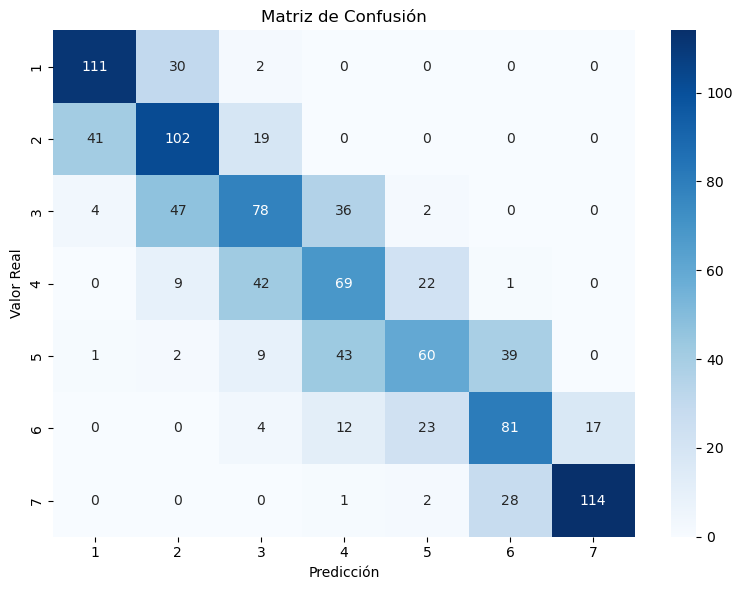

Accuracy: 0.5852
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.78      0.74       143
           2       0.54      0.63      0.58       162
           3       0.51      0.47      0.49       167
           4       0.43      0.48      0.45       143
           5       0.55      0.39      0.46       154
           6       0.54      0.59      0.57       137
           7       0.87      0.79      0.83       145

    accuracy                           0.59      1051
   macro avg       0.59      0.59      0.59      1051
weighted avg       0.59      0.59      0.58      1051



In [311]:
y_test, y_pred = train_decision_tree_classifier(df_scaled_no_comodidades_with_range_price)
accuracy_classification(y_test, y_pred)
heatmap_confusion_matrix(y_test, y_pred)
y_test, y_pred = train_decision_tree_classifier(df_scaled_with_range_price[new_range_price_columns])
accuracy_classification(y_test, y_pred)

### Modelo de regresión decision tree

In [312]:
from sklearn.tree import DecisionTreeRegressor

def regression_tree_decision(df_):
    X = df_.drop(columns=["price"])
    y = df_["price"]  # No convertir a int si es continua

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = DecisionTreeRegressor(max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    calcular_medape(y_test, y_pred)
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
    return model, y_test, y_pred, X
model, y_test, y_pred, X =regression_tree_decision(df_scaled)

MAPE: 22.25%
MEDAPE: 17.47%
MAE: 0.0120
RMSE: 0.0233
R² Score: 0.8093


In [313]:
model, y_test, y_pred, X=regression_tree_decision(df_scaled[new_main_columns])

MAPE: 22.33%
MEDAPE: 17.86%
MAE: 0.0124
RMSE: 0.0263
R² Score: 0.7578


MAPE: 22.20%
MEDAPE: 17.54%
MAE: 0.0118
RMSE: 0.0230
R² Score: 0.8149


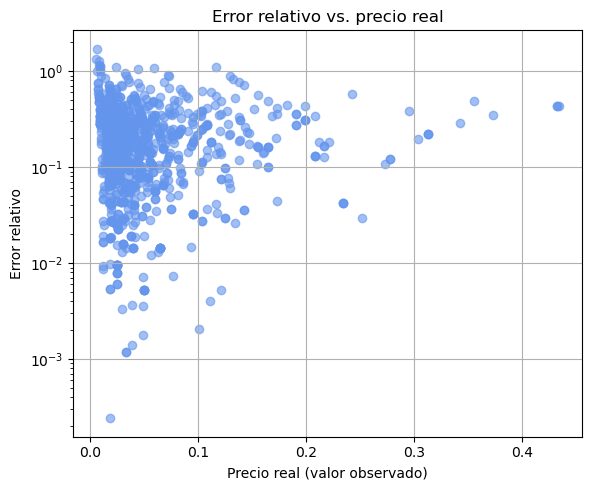

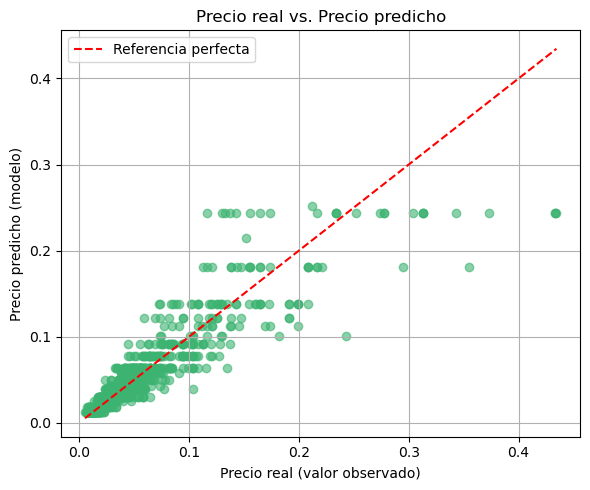

                                 Feature  Importance
2                         areaConstruida        0.73
7                     antiguedad_encoded        0.10
5                         administracion        0.06
3                            areaPrivada        0.05
6                                estrato        0.03
11                  estadoInmueble_Nuevo        0.02
4                           parqueaderos        0.01
0                           habitaciones        0.00
1                                 banyos        0.00
8              estadoInmueble_Buenestado        0.00
9         estadoInmueble_Excelenteestado        0.00
10        estadoInmueble_No especificado        0.00
12  estadoInmueble_Requieremantenimiento        0.00


In [314]:
model, y_test, y_pred, X=regression_tree_decision(df_scaled_no_comodidades)
scatterplot_prediccion_error(y_test, y_pred)
scatterplot_real_vs_predicho(y_test, y_pred)
feature_importance(model, X)

### Modelo de regresión MLP

In [315]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mlp_regression(df_):
    X = df_.drop(columns=["price"])
    y = df_["price"]

    # Normalizar
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    # Dividir
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Modelo
    mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predicción
    y_pred = mlp.predict(X_test)

    # Evaluación
    calcular_medape(y_test, y_pred)
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
    return y_test, y_pred, mlp, X_test

y_test, y_pred, model, X_test =mlp_regression(df_scaled)

MAPE: 63.38%
MEDAPE: 40.89%
MAE: 0.0221
RMSE: 0.0314
R² Score: 0.6540


In [316]:
y_test, y_pred, model, X_test=mlp_regression(df_scaled[new_main_columns])

MAPE: 21.65%
MEDAPE: 15.44%
MAE: 0.0102
RMSE: 0.0197
R² Score: 0.8644


MAPE: 30.19%
MEDAPE: 22.41%
MAE: 0.0119
RMSE: 0.0189
R² Score: 0.8745


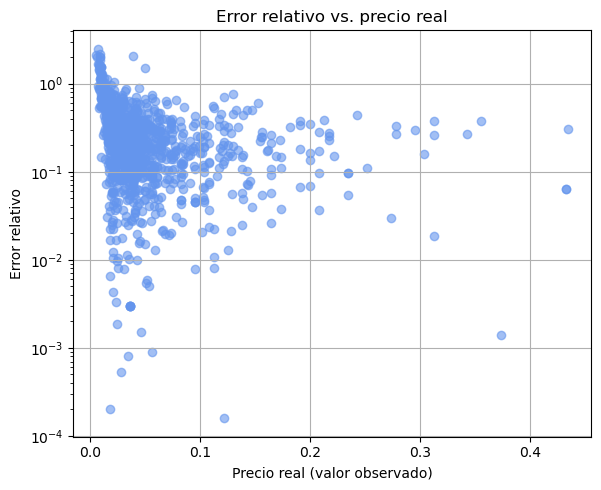

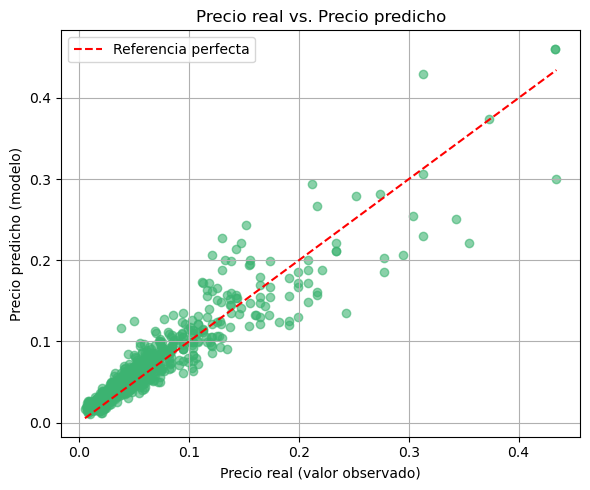

                                 Feature  Importance
10        estadoInmueble_No especificado        0.22
2                         areaConstruida        0.20
3                            areaPrivada        0.15
7                     antiguedad_encoded        0.13
9         estadoInmueble_Excelenteestado        0.11
8              estadoInmueble_Buenestado        0.07
11                  estadoInmueble_Nuevo        0.04
5                         administracion        0.03
1                                 banyos        0.02
4                           parqueaderos        0.01
6                                estrato        0.01
0                           habitaciones        0.01
12  estadoInmueble_Requieremantenimiento        0.00


In [317]:
y_test, y_pred, model, X_test=mlp_regression(df_scaled_no_comodidades)
scatterplot_prediccion_error(y_test, y_pred)
scatterplot_real_vs_predicho(y_test, y_pred)
permu_importance(model, X_test, y_test)

### Modelo de clasificación MLP

In [318]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def mlp_classification(df_):
    X = df_.drop(columns=["range_price"])
    y = df_["range_price"].astype(int)  # Asegúrate de que sean clases enteras

    # Normalizar
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modelo
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)

    # Predicción
    y_pred = mlp.predict(X_test)
    return y_test, y_pred

y_test, y_pred=mlp_classification(df_scaled_with_range_price)
accuracy_classification(y_test, y_pred)

Accuracy: 0.6337
Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.81      0.74       143
           2       0.60      0.55      0.57       162
           3       0.60      0.51      0.55       167
           4       0.54      0.61      0.57       143
           5       0.56      0.56      0.56       154
           6       0.59      0.56      0.57       137
           7       0.87      0.86      0.87       145

    accuracy                           0.63      1051
   macro avg       0.63      0.64      0.63      1051
weighted avg       0.63      0.63      0.63      1051



Accuracy: 0.6384
Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.78      0.72       143
           2       0.60      0.56      0.58       162
           3       0.64      0.61      0.62       167
           4       0.51      0.51      0.51       143
           5       0.57      0.64      0.60       154
           6       0.68      0.48      0.56       137
           7       0.81      0.90      0.85       145

    accuracy                           0.64      1051
   macro avg       0.64      0.64      0.64      1051
weighted avg       0.64      0.64      0.63      1051

Accuracy: 0.6403
Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.78      0.73       143
           2       0.60      0.57      0.59       162
           3       0.62      0.65      0.63       167
           4       0.53      0.49      0.51       143
           5       0.61      0.62      0.62       

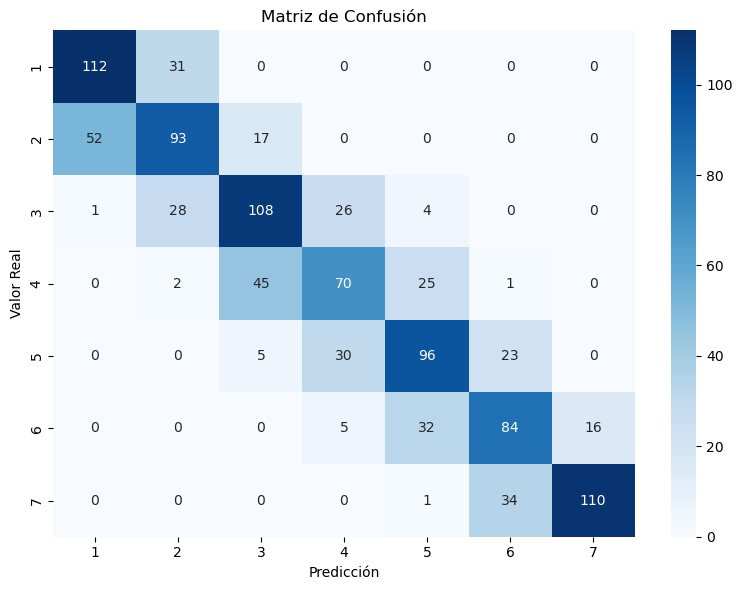

In [319]:
y_test, y_pred = mlp_classification(df_scaled_no_comodidades_with_range_price)
accuracy_classification(y_test, y_pred)
y_test, y_pred = mlp_classification(df_scaled_with_range_price[new_range_price_columns])
accuracy_classification(y_test, y_pred)
heatmap_confusion_matrix(y_test, y_pred)

### Modelo de clasificación KNN

In [320]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def knn_classification(df_, n_neighbors=5):
    X = df_.drop(columns=["range_price"])
    y = df_["range_price"].astype(int)

    # Normalizar (obligatorio para KNN)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modelo
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # Predicción
    y_pred = knn.predict(X_test)
    return y_test, y_pred

y_test, y_pred = knn_classification(df_scaled_with_range_price)
accuracy_classification(y_test, y_pred)

Accuracy: 0.4082
Classification Report:
               precision    recall  f1-score   support

           1       0.52      0.72      0.60       143
           2       0.38      0.40      0.39       162
           3       0.33      0.31      0.32       167
           4       0.27      0.33      0.30       143
           5       0.32      0.24      0.28       154
           6       0.38      0.40      0.39       137
           7       0.76      0.49      0.60       145

    accuracy                           0.41      1051
   macro avg       0.42      0.41      0.41      1051
weighted avg       0.42      0.41      0.41      1051



Accuracy: 0.6251
Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.81      0.74       143
           2       0.60      0.59      0.59       162
           3       0.61      0.54      0.57       167
           4       0.51      0.50      0.51       143
           5       0.55      0.55      0.55       154
           6       0.57      0.58      0.57       137
           7       0.85      0.83      0.84       145

    accuracy                           0.63      1051
   macro avg       0.62      0.63      0.63      1051
weighted avg       0.62      0.63      0.62      1051

Accuracy: 0.6327
Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.81      0.76       143
           2       0.62      0.59      0.60       162
           3       0.61      0.57      0.59       167
           4       0.49      0.51      0.50       143
           5       0.56      0.55      0.55       

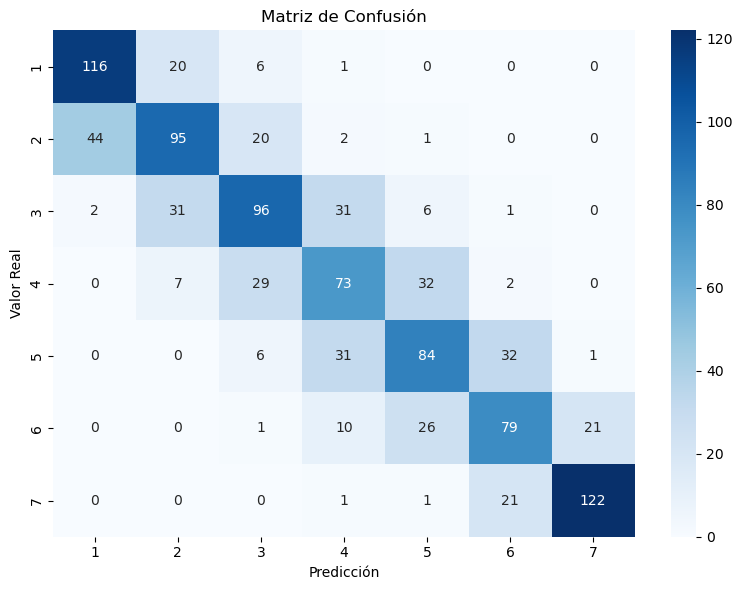

In [321]:
y_test, y_pred = knn_classification(df_scaled_no_comodidades_with_range_price)
accuracy_classification(y_test, y_pred)
y_test, y_pred = knn_classification(df_scaled_with_range_price[new_range_price_columns])
accuracy_classification(y_test, y_pred)
heatmap_confusion_matrix(y_test, y_pred)

## Análisis modelos de clasificación

•	Los modelos basados en árboles combinados como Gradient Boosting y Random Forest demostraron ser los más efectivos para la clasificación del rango de precios, con precisiones superiores al 68%. Otros enfoques como árboles simples, redes neuronales y KNN mostraron un rendimiento inferior, evidenciando la complejidad del problema y la necesidad de modelos robustos que manejen relaciones no lineales y variables con distintos niveles de importancia.

•	MLP Classifier (red neuronal) logró un resultado aceptable (67%), aunque menor que los ensembles.  Por otra parte el decision tree alcanzó un 66%, lo cual es razonable, pero confirma que un solo árbol es menos robusto frente a la complejidad del problema en comparación con sus versiones agrupadas.
•	K-Nearest Neighbors (KNN) obtuvo el peor resultado (65%), lo cual es común en datasets con muchas variables continuas, además,  sufre con clases desbalanceadas y ruido, por lo que no es sorprendente su bajo desempeño aquí.

•	La matriz de confusión en cada modelo aplicado mostró un mayor desempeño en la clasificación de apartamentos en los extremos del rango de precios, particularmente en las clases 1 (muy barato) y 7 (muy costoso), donde se alcanzan los niveles más altos de precisión y recall. Sin embargo, se evidencian dificultades para diferenciar las clases intermedias (2 a 6), donde es frecuente la confusión entre etiquetas consecutivas. Esto sugiere que los patrones de estas clases son más similares o menos definidos, lo cual representa un reto adicional para la predicción.

•	Los modelos basados en árboles combinados como Gradient Boosting y Random Forest demostraron ser los más efectivos para la clasificación del rango de precios, con precisiones superiores al 68%. Otros enfoques como árboles simples, redes neuronales y KNN mostraron un rendimiento inferior, evidenciando la complejidad del problema y la necesidad de modelos robustos que manejen relaciones no lineales y variables con distintos niveles de importancia.

•	Las tres métricas evaluadas (accuracy, precision y recall macro) mostraron un comportamiento muy similar entre sí. Esto puede explicarse por el uso de 7 clases con una distribución equilibrada de ejemplos, lo que evitó que alguna clase dominara o quedara subrepresentada en el cálculo. Además, los modelos no presentaron dificultades particulares para clasificar una clase específica, lo que contribuyó a que el rendimiento fuera relativamente uniforme en todas ellas.


## Análisis modelos de regresión

•  El modelo Random Forest Regressor obtuvo el menor error absoluto (MAE) y relativo (MEDAPE), además de posicionarse como el segundo mejor modelo en términos de r², lo que indica un equilibrio sólido entre precisión general y estabilidad frente a outliers.

•  El modelo Gradient Boosting Regressor logró el mejor desempeño en r², lo que sugiere que explica mejor la varianza de los precios. Sin embargo, su error absoluto y relativo fue ligeramente mayor que el de Random Forest, probablemente debido a su mayor sensibilidad a valores extremos


•  La diferencia entre ambos modelos sugiere que Random Forest es más robusto frente a outliers, mientras que Gradient Boosting ofrece mejor ajuste general, aunque a costa de algunos errores más grande

.
•  En todos los modelos se observó que el MAPE se disparaba por culpa de unos pocos outliers, especialmente en propiedades con precios bajos. Esto es esperado, ya que errores pequeños en valores bajos generan porcentajes desproporcionadamente alt

s.
•  En el caso de la regresión lineal, fue necesario excluir variables de comodidades para mitigar la generación de outliers. Esto indica que los datos no siguen una relación lineal simple, y que modelos más complejos como Random Forest o Gradient Boosting capturan mejor la estructura no lineal del mercado.
